In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import beta
from scipy.interpolate import interp1d, interp2d
from scipy.integrate import quad, quad_vec
import lhapdf
import h5py
from scipy.special import beta, digamma, gamma, loggamma, polygamma
import matplotlib.gridspec as gridspec

"""
Mc = 1.3
Mb = 4.2
Mz = 91.7

b0_q = 2./(11.-2./3.*3);
b0_c = 2./(11.-2./3.*4);
b0_b = 2./(11.-2./3.*5);
alphas_Mz_bar = 0.118 / 2. / np.pi;
Lambda2_b = Mz**2/np.exp(b0_b/alphas_Mz_bar);
a5_Mb_bar = b0_b/np.log((2*Mb)**2/Lambda2_b);
Lambda2_c = (2*Mb)**2/np.exp(b0_c/a5_Mb_bar);
a4_Mc_bar = b0_c/np.log((2*Mc)**2/Lambda2_c);
Lambda2_q = (2*Mc)**2/np.exp(b0_q/a4_Mc_bar);

NPscale2 = Lambda2_q * 4.0;
a3_NP_bar = b0_q/np.log(NPscale2/Lambda2_q);


tc = b0_q*np.log(np.log(4*Mc*Mc/Lambda2_q));
tb = b0_c*np.log(np.log(4*Mb*Mb/Lambda2_c))\
   - b0_c*np.log(np.log(4*Mc*Mc/Lambda2_c))\
   + b0_q*np.log(np.log(4*Mc*Mc/Lambda2_q));


LO, varaible flavor
@np.vectorize
def alpha(Q2):
    Q2 = np.max([NPscale2, Q2])
    if Q2<4*Mc*Mc:
        return 2.*np.pi*b0_q/np.log(Q2/Lambda2_q)
    elif Q2<4*Mb*Mb:
        return 2.*np.pi*b0_c/np.log(Q2/Lambda2_c)
    else:
        return 2.*np.pi*b0_b/np.log(Q2/Lambda2_b)
        

# convert Q2 to the integration variable: dt = -2/beta * dln alpha
def Q2_to_t(Q2):
    Q2 = np.max([NPscale2, Q2])
    if Q2<4*Mc*Mc:
        return - b0_q * np.log(alpha(Q2)/2/np.pi/a3_NP_bar)
    elif Q2<4*Mb*Mb:
        return - b0_c * np.log(alpha(Q2)/2/np.pi/a4_Mc_bar) \
               - b0_q * np.log(a4_Mc_bar/a3_NP_bar)
    else:
        return - b0_b * np.log(alpha(Q2)/2/np.pi/a5_Mb_bar)\
               - b0_c * np.log(a5_Mb_bar/a4_Mc_bar) \
               - b0_q * np.log(a4_Mc_bar/a3_NP_bar)
               
print("alpha_s(Mz) =", alpha(Mz**2))
"""


'\nMc = 1.3\nMb = 4.2\nMz = 91.7\n\nb0_q = 2./(11.-2./3.*3);\nb0_c = 2./(11.-2./3.*4);\nb0_b = 2./(11.-2./3.*5);\nalphas_Mz_bar = 0.118 / 2. / np.pi;\nLambda2_b = Mz**2/np.exp(b0_b/alphas_Mz_bar);\na5_Mb_bar = b0_b/np.log((2*Mb)**2/Lambda2_b);\nLambda2_c = (2*Mb)**2/np.exp(b0_c/a5_Mb_bar);\na4_Mc_bar = b0_c/np.log((2*Mc)**2/Lambda2_c);\nLambda2_q = (2*Mc)**2/np.exp(b0_q/a4_Mc_bar);\n\nNPscale2 = Lambda2_q * 4.0;\na3_NP_bar = b0_q/np.log(NPscale2/Lambda2_q);\n\n\ntc = b0_q*np.log(np.log(4*Mc*Mc/Lambda2_q));\ntb = b0_c*np.log(np.log(4*Mb*Mb/Lambda2_c))   - b0_c*np.log(np.log(4*Mc*Mc/Lambda2_c))   + b0_q*np.log(np.log(4*Mc*Mc/Lambda2_q));\n\n\nLO, varaible flavor\n@np.vectorize\ndef alpha(Q2):\n    Q2 = np.max([NPscale2, Q2])\n    if Q2<4*Mc*Mc:\n        return 2.*np.pi*b0_q/np.log(Q2/Lambda2_q)\n    elif Q2<4*Mb*Mb:\n        return 2.*np.pi*b0_c/np.log(Q2/Lambda2_c)\n    else:\n        return 2.*np.pi*b0_b/np.log(Q2/Lambda2_b)\n        \n\n# convert Q2 to the integration variable: dt = -

In [2]:
# QCD stuff


CA = 3.
CF = 4./3.
TR = 1./2.
Nf = 4 # For jetpT*R>2*charm mass, but below 2*bottom mass

beta0_eff = (11.-2./3.*Nf)
beta1_eff = (102.-38./3.*Nf)
P = lhapdf.mkPDF("CT14nlo/0")
def alpha(Q2):
    return P.alphasQ2(Q2)
def Q2_to_t(Q2):
    return -2/beta0_eff * (  np.log(alpha(Q2))
                           - np.log(1+beta1_eff/beta0_eff/4/np.pi*alpha(Q2)) )

    


LHAPDF 6.4.0 loading /home/weiyaoke/.local/share/LHAPDF/CT14nlo/CT14nlo_0000.dat
CT14nlo PDF set, member #0, version 1; LHAPDF ID = 13100


In [3]:
# Vacuum DGLAP kernel in the Melin space
# f(N) = int_0^1 dz z^{N-1} f(z)
def Mqq(N):
    return CF * (3./2. - (1+2*N)/(N*(N+1)) - 2.*np.euler_gamma - 2.*digamma(N) ) 
def Mqg(N):
    return CF * (N**2 + N + 2) / (N**3 - N) 
def Mgg(N):
    return CA * ( 2./(N*(N-1)) + 2/((N+1)*(N+2)) - 2.*np.euler_gamma - 2.*digamma(N+1) )\
         + beta0_eff/2.
def Mgq(N):
    return TR*(N**2+N+2)/(N*(N+1)*(N+2))

In [4]:
# LO + NLO initial conditon
gE = np.euler_gamma
gE2 = gE**2
pi2 = np.pi**2

A0 = -96
A1 = -(72+96*gE)
A2 = (264-168*gE-24*gE2-4*pi2)
A3 = (396-12*gE-48*gE2-8*pi2)
A4 = (240+144*gE-6*gE2-pi2)
A5 = (60+108*gE+42*gE2+7*pi2)
A6 = (24*gE+30*gE2+5*pi2)
A7 = (6*gE2+pi2)
B21 = 5+2*gE
B22 = 2+3*gE

dJq = CF*pi2/12. + CF*(13./2.-2*pi2/3.)
dJg = CA*np.pi**2/12. + CA*(67/9.-2*np.pi**2/3.) - TR*Nf*23./9.

def IC(N, abar0, order):
    # LO
    if order=='LO':
        return 1, 1
    
    # NLO
    N2 = N**2
    N3 = N*N2
    N4 = N2**2
    N5 = N4*N
    N6 = N4*N2
    N7 = N6*N
    
    Nm1 = N-1
    Np1 = N+1
    Np2 = N+2
    N2_N_2 = N2+N+2
    digammaN = digamma(N)
    digammaNm1 = digamma(N-1)
    trigammaN = (digamma(N+.01)-digamma(N-.01))/.02
    trigammaNm1 = (digamma(N-1+.01)-digamma(N-1-.01))/.02
    
    # NLO quark
    A = 1/(N*Np1)**2 + (3+gE+gE*N*(2+gE+gE*N))/N/Np1 + pi2/6.\
      + digammaN*(2*gE+1/N+1/Np1+digammaN) - trigammaN
    
    B = (2+3*N)/(N*Np1)**2 - (gE+digammaN)*N2_N_2/(Nm1*N*Np1)
    S1q = 2*CF*A + CF/N - dJq + 2*CF*B
    
    # NLO gluon
    A = 1./(12*Nm1*(N*Np1*Np2)**2) * (
        A0 + A1*N + A2*N2 + A3*N3 + A4*N4 + A5*N5 + A6*N6 + A7*N7
        +12*digammaNm1*(-2*N-N2+2*N3+N4)*(4+B21*N+B22*N2+gE*N3)
        +6*(digammaNm1**2-trigammaNm1)*Nm1*N2*(2+3*N+N2)**2
    )

    B = 1./(Np1*Np2)**2 * (4+N-N2 - Np1*Np2*N2_N_2/N*(gE+digamma(N+1)) )
    S1g = 4*CA*A - dJg + 4*Nf*TR*B
    return  - abar0 * S1q,  - abar0 * S1g


In [5]:
# The evolution matrix
def Mevo(N, dt):
    a = Mqq(N); b = Mqg(N)
    c = 2*Nf*Mgq(N); d = Mgg(N)

    Delta = np.sqrt( (a-d)**2 + 4.*b*c)
    S1 = np.exp(dt * ( a + d - Delta ) / 2. )
    S2 = np.exp(dt * ( a + d + Delta ) / 2. )
    A = (a - d - Delta)/2.
    B = (a - d + Delta)/2.
    
    E1 = np.array([[A, b],
                   [c,-B]]) * S1
    E2 = np.array([[B, b],
                   [c,-A]]) * S2
    return (E2 - E1)/Delta

In [6]:
# Solution in Mellin space
def RG_MJ(N, dt, abar0, order):
    Matrix = Mevo(N, dt)
    Jq0, Jg0 = IC(N, abar0, order)
    return Matrix[0,0]*Jq0 + Matrix[0,1]*Jg0, Matrix[1,0]*Jq0 + Matrix[1,1]*Jg0

# Tranform back to real space
@np.vectorize
def RG_J(zz, Q2max, Q2min, order='LO'):
    ReN = 2.5
    phi = 3./4.*np.pi
    lnz = np.log(zz)
    dt  = Q2_to_t(Q2max) - Q2_to_t(Q2min)
    Ephi = np.exp(1j*phi)
    Ephi_c = np.exp(-1j*phi)
    abar0 = alpha(Q2min)/2/np.pi
    
    def df(ln1px):
        x = np.exp(ln1px) - 1.
        
        # upper contour
        N = ReN + x*Ephi
        MJq, MJg = RG_MJ(N, dt, abar0, order)
        IM_up = np.exp( - N*lnz + 1j*phi - 1j*np.pi/2)
        QA = (MJq * IM_up).real
        GA = (MJg * IM_up).real

        # the negative of the lower contour
        N = ReN + x*Ephi_c
        MJq, MJg = RG_MJ(N, dt, abar0, order)
        IM_down = np.exp( - N*lnz - 1j*phi - 1j*np.pi/2)
        QB = (MJq * IM_down).real
        GB = (MJg * IM_down).real
        return np.array([ QA-QB, GA-GB ]) * (1+x) # with Jacobian

    
    Jq, Jg = quad_vec(df, 0, np.log(1-40/lnz), epsrel=.01)[0]
    return Jq/2/np.pi , Jg/2/np.pi 

In [7]:
# grid with good resolution near z=0,1
u = np.linspace(np.log(.01),-np.log(.001),31)
z = 1/(1+np.exp(-u))

/tmp/ipykernel_1331420/666427123.py:41: MatplotlibDeprecationWarning: Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  plt.tight_layout(True)


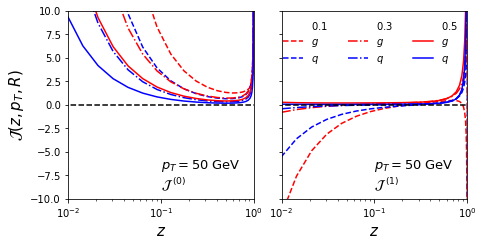

In [8]:
pT = 50
Q2max = pT**2
Rs = [.1,.3,.5]

fig, (ax, ax1) = plt.subplots(1,2,figsize=(6.8,3.5), sharex=True, sharey=True)
for R, line in zip(Rs, ['--','-.','-']):
    Q2min = (pT*R)**2
    Jq, Jg = RG_J(z, Q2max, Q2min, order='LO')
    ax.plot([],[],color='none',label='${}$'.format(R))
    ax.plot(z, Jg, line, color='r', label=r'$g$')
    ax.plot(z, Jq, line, color='b', label=r'$q$')


ax.plot([0,1],[0,0],'k--')
ax.set_xlabel("$z$", fontsize=15)
ax.set_ylabel("$\mathcal{J}(z, p_T, R)$", fontsize=15)
ax.annotate(r"$p_T={}$ GeV".format(pT)+'\n'+'$\mathcal{J}^{~(0)}$', xy=(.5,.05), xycoords="axes fraction",fontsize=13)
ax.set_xlim(0.01,1)
ax.set_ylim(-10,10)
ax.semilogx()


ax = ax1
for R, line in zip(Rs, ['--','-.','-']):
    Q2min = (pT*R)**2
    Jq, Jg = RG_J(z, Q2max, Q2min, order='NLO')
    ax.plot([],[],color='none',label='${}$'.format(R))
    ax.plot(z, Jg, line, color='r', label=r'$g$')
    ax.plot(z, Jq, line, color='b', label=r'$q$')


ax.plot([0,1],[0,0],'k--')
ax.set_xlabel("$z$", fontsize=15)
ax.annotate(r"$p_T={}$ GeV".format(pT)+'\n'+'$\mathcal{J}^{~(1)}$', xy=(.5,.05), xycoords="axes fraction",fontsize=13)
ax.set_xlim(0.01,1)
ax.set_ylim(-10,10)
ax.semilogx()
ax.legend(ncol=3, framealpha=0)


plt.tight_layout(True)
plt.subplots_adjust(wspace=.15)
plt.savefig("JetFunctions-R.png", dpi=300)

In [9]:
# Tabulate jet function
pTjets = np.exp(np.linspace(np.log(5),np.log(2000),40))
Rs = np.array([0.1, 0.2, 0.3, 0.4])
z1mz_JF_data = {'q': {'LO':[], 'NLO':[]},
                'g': {'LO':[], 'NLO':[]},
                'R' : Rs,
                'pT': pTjets,
                'z' : z
                }

for i, R in enumerate(Rs):
    
    z1mz_JF_data['q']['LO'].append([])
    z1mz_JF_data['g']['LO'].append([])
    for pTjet in pTjets:
        Q2max = pTjet**2
        Q2min = (pTjet*R)**2
        Jq, Jg = RG_J(z, Q2max, Q2min, 'LO')
        z1mz_JF_data['q']['LO'][-1].append(z*(1-z)*Jq)
        z1mz_JF_data['g']['LO'][-1].append(z*(1-z)*Jg)
        
    z1mz_JF_data['q']['NLO'].append([])
    z1mz_JF_data['g']['NLO'].append([])
    for pTjet in pTjets:
        Q2max = pTjet**2
        Q2min = (pTjet*R)**2
        Jq, Jg = RG_J(z, Q2max, Q2min, 'NLO')
        z1mz_JF_data['q']['NLO'][-1].append(z*(1-z)*Jq)
        z1mz_JF_data['g']['NLO'][-1].append(z*(1-z)*Jg)

In [10]:
# Interpolate z*(1-z)*JF for each order and each R as function of lnpTjet and z
z1mz_JF = {'q': {'LO':[], 'NLO':[]},
           'g': {'LO':[], 'NLO':[]}
          }
for i, R in enumerate(Rs):
    lnpT = np.log(pTjets)
    for sp in 'qg':
        for order in ['LO', 'NLO']:
            z1mz_JF[sp][order].append(interp2d(lnpT, z, np.array(z1mz_JF_data[sp][order][i]).T, 
                                               kind='cubic', fill_value=0., bounds_error=False))

def JF(pT, z, iR, specie, order):
    return z1mz_JF[specie][order][iR](np.log(pT), z)/z/(1-z)

In [11]:
@np.vectorize
def sigma_fold_JF(pTjet, ln_dsigma_dpT, RR, iR, specie, order='LO'):
    Q2max = pTjet**2
    Q2min = pTjet**2*RR**2
    abar0 = alpha(Q2min)/2/np.pi
    
    ez = .01
    zmax = 1-ez
    umax = np.log(1/(1-zmax))
    
    # from 0 to 1-ez
    def df(u):
        z = 1 - np.exp(-u)
        Jacobian = (1-z)/z
        res = np.exp(ln_dsigma_dpT(np.log(pTjet/z)))*JF(pTjet, z, iR, specie, order)
        return res * Jacobian
    A = quad(df, ez, umax)[0]
    
    # from 1-ez to ez
    Nfix = 6
    def df2(u):
        z = 1 - np.exp(-u)
        Jacobian = (1-z)
        return JF(pTjet, z, iR, specie, order) * z**(Nfix-1) * Jacobian
    
    subtraction = quad(df2, 0, umax)[0]
    JqNm1, JgNm1 = RG_MJ(Nfix, 
                         Q2_to_t(Q2max) - Q2_to_t(Q2min),
                         abar0, order)
    sigma0 = np.exp(ln_dsigma_dpT(np.log(pTjet)))
    B = sigma0*((JqNm1 if specie=='q' else JgNm1) - subtraction)
                
    return A + B


In [12]:
def MakeSpectra(x, y):
    return interp1d(np.log(x), np.log(1e-35+y), fill_value=np.log(1e-35), bounds_error=False)

# STAR 200 GeV, R=0.4

In [20]:
# https://journals.aps.org/prl/pdf/10.1103/PhysRevLett.97.252001
# quark spectra, LO and NLO correction
pT, dsigma_dpT_dy_g_lo = np.loadtxt("/home/weiyaoke/Research/NLO_initial_parton_spectra/qqbar/pp2g-200GeV-LO-CT14nlo.dat").T
pT, dsigma_dpT_dy_g_nlo = np.loadtxt("/home/weiyaoke/Research/NLO_initial_parton_spectra/qqbar/pp2g-200GeV-NLO-CT14nlo.dat").T
dsigma_dpT_dy_g_nlo -= dsigma_dpT_dy_g_lo

# qluon spectra, LO and NLO correction
pT, dsigma_dpT_dy_q_lo = np.loadtxt("/home/weiyaoke/Research/NLO_initial_parton_spectra/qqbar/pp2qqbar-200GeV-LO-CT14nlo.dat").T
pT, dsigma_dpT_dy_q_nlo = np.loadtxt("/home/weiyaoke/Research/NLO_initial_parton_spectra/qqbar/pp2qqbar-200GeV-NLO-CT14nlo.dat").T
dsigma_dpT_dy_q_nlo -= dsigma_dpT_dy_q_lo

R, iR = 0.4, 3
# LO jet cross section, parton level
dsigma_dpT_dy_LO = dsigma_dpT_dy_q_lo + dsigma_dpT_dy_g_lo

pp2q2J_00 = 1.*dsigma_dpT_dy_q_lo
pp2q2J_01 = sigma_fold_JF(pT,  MakeSpectra(pT, dsigma_dpT_dy_q_lo), R, iR, 'q', 'NLO')
pp2q2J_10 = sigma_fold_JF(pT,  MakeSpectra(pT, dsigma_dpT_dy_q_nlo), R, iR, 'q', 'LO')
pp2g2J_00 = 1.*dsigma_dpT_dy_g_lo 
pp2g2J_01 = sigma_fold_JF(pT,  MakeSpectra(pT, dsigma_dpT_dy_g_lo), R, iR, 'g', 'NLO')
pp2g2J_10 = sigma_fold_JF(pT,  MakeSpectra(pT, dsigma_dpT_dy_g_nlo), R, iR, 'g', 'LO')

with open("pp2q2J-200GeV-R0d4.dat",'w') as file:
    for (ipT, a,b,c,d,e,f) in zip(pT, pp2q2J_00, pp2q2J_01, pp2q2J_10, 
                                 pp2g2J_00, pp2g2J_01, pp2g2J_10):
        file.write("{:1.3f}\t{:1.3e}\t{:1.3e}\t{:1.3e}\t{:1.3e}\t{:1.3e}\t{:1.3e}\n".format(ipT, a,b,c,d,e,f))



def plot_exp(ax, color='k', scale=lambda x: 0):
    pT, pTl, pTh, y, stat, _, sys, _ = np.loadtxt("./Data/STAR-pp200-R0.4.dat").T
    # pb -> mb
    y *= 1e-9 * 2*np.pi
    stat *= 1e-9 * 2*np.pi
    sys *= 1e-9 * 2*np.pi
    y0 = np.array([np.exp(scale(np.log(np.linspace(L,H,10)))).mean() 
                         for L, H in zip(pTl, pTh)])
    y /= y0
    stat /= y0
    sys /= y0
    ax.errorbar(pT, y, xerr=(pTh-pTl)/2., yerr=stat, fmt='.', color=color)
    
    for il, ih, yl, yh in zip(pTl, pTh, y-sys, y+sys):
        ax.fill_between([il,ih], [yl,yl], [yh,yh], facecolor='none', edgecolor=color)

/tmp/ipykernel_1331420/2827746042.py:45: MatplotlibDeprecationWarning: Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  plt.tight_layout(True)


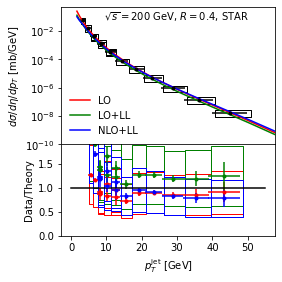

In [17]:
R, iR = 0.4, 3

# LO + LL
dsigma_dpT_dy_LO_LL = sigma_fold_JF(pT,  MakeSpectra(pT, dsigma_dpT_dy_q_lo), R, iR, 'q', 'LO')\
                    + sigma_fold_JF(pT,  MakeSpectra(pT, dsigma_dpT_dy_g_lo), R, iR, 'g', 'LO')
# LO + LL + NLL
dsigma_dpT_dy_NLO_LL = dsigma_dpT_dy_LO_LL\
                     + sigma_fold_JF(pT,  MakeSpectra(pT, dsigma_dpT_dy_q_lo), R, iR, 'q', 'NLO')\
                     + sigma_fold_JF(pT,  MakeSpectra(pT, dsigma_dpT_dy_g_lo), R, iR, 'g', 'NLO')\
                     + sigma_fold_JF(pT,  MakeSpectra(pT, dsigma_dpT_dy_q_nlo), R, iR, 'q', 'LO')\
                     + sigma_fold_JF(pT,  MakeSpectra(pT, dsigma_dpT_dy_g_nlo), R, iR, 'g', 'LO')

fig = plt.figure(figsize=(4,4))
gs = gridspec.GridSpec(5, 1)
ax1 = fig.add_subplot(gs[:3])
ax2 = fig.add_subplot(gs[3:])

# dsigma/dpT/dy
ax1.plot(pT, dsigma_dpT_dy_LO, 'r', label='LO')
ax1.plot(pT, dsigma_dpT_dy_LO_LL, 'g', label='LO+LL')
ax1.plot(pT, dsigma_dpT_dy_NLO_LL, 'b', label="NLO+LL")
plot_exp(ax1)

ax1.semilogy()
ax1.set_ylim(1e-10,5e-1)
ax1.set_xlim(0,55)
ax1.set_xticks([])
ax1.legend(loc='lower left', framealpha=0.)
ax1.set_ylabel(r"$d\sigma/d\eta/dp_T$ [mb/GeV]")
ax1.annotate(r"$\sqrt{s}=200$ GeV, $R=0.4$, STAR", xy=(.2,.9), xycoords='axes fraction')

# Exp/Theory
plot_exp(ax2, color='r', scale=MakeSpectra(pT, dsigma_dpT_dy_LO) )
plot_exp(ax2, color='g', scale=MakeSpectra(pT, dsigma_dpT_dy_LO_LL) )
plot_exp(ax2, color='b', scale=MakeSpectra(pT, dsigma_dpT_dy_NLO_LL) )

ax2.set_ylim(0,1.9)
ax2.plot([0,55],[1,1], 'k-')
ax1.set_xlim(0,55)
ax2.set_xlabel(r"$p_T^{\rm jet}$ [GeV]")
ax2.set_ylabel(r"Data/Theory")



plt.tight_layout(True)
plt.subplots_adjust(hspace=0)
plt.savefig("STAR-jet-R0d4.png", dpi=300)


# ATLAS 7 TeV, R=0.4

In [24]:
# quark spectra, LO and NLO correction
pT, dsigma_dpT_dy_g_lo = np.loadtxt("/home/weiyaoke/Research/NLO_initial_parton_spectra/qqbar/pp2g-7TeV-LO-CT14nlo.dat").T
pT, dsigma_dpT_dy_g_nlo = np.loadtxt("/home/weiyaoke/Research/NLO_initial_parton_spectra/qqbar/pp2g-7TeV-NLO-CT14nlo.dat").T
dsigma_dpT_dy_g_nlo -= dsigma_dpT_dy_g_lo

# qluon spectra, LO and NLO correction
pT, dsigma_dpT_dy_q_lo = np.loadtxt("/home/weiyaoke/Research/NLO_initial_parton_spectra/qqbar/pp2qqbar-7TeV-LO-CT14nlo.dat").T
pT, dsigma_dpT_dy_q_nlo = np.loadtxt("/home/weiyaoke/Research/NLO_initial_parton_spectra/qqbar/pp2qqbar-7TeV-NLO-CT14nlo.dat").T
dsigma_dpT_dy_q_nlo -= dsigma_dpT_dy_q_lo

# LO jet cross section, parton level
dsigma_dpT_dy_LO = dsigma_dpT_dy_q_lo + dsigma_dpT_dy_g_lo

# Load data
def plot_exp(ax, color='k', scale=lambda x: 0):
    pT, pTl, pTh, y, stat, _ = np.loadtxt("./Data/ATLAS-pp7000-jet.dat").T
    # pb -> mb
    y /= 10**9
    stat = y*stat/100
    #(A, B), _ = curve_fit(template, np.log(pT), np.log(y))
    #print(A, B)
    y0 = np.array([np.exp(scale(np.log(np.linspace(L,H,10)))).mean() 
                         for L, H in zip(pTl, pTh)])
    y /= y0
    stat /= y0
    ax.errorbar(pT, y, xerr=(pTh-pTl)/2., yerr=stat, fmt='.', color=color)

[  50.     61.36   75.3    92.4   113.4   139.2   170.8   209.6   257.2
  315.6   387.3   475.3   583.3   715.8   878.4  1078.   1323.   1623.
 1992.   2445.   3000.  ]


In [21]:
R, iR = 0.2, 1
# LO + LL
#dsigma_dpT_dy_LO_LL = sigma_fold_JF(pT,  MakeSpectra(pT, dsigma_dpT_dy_q_lo), R, iR, 'q', 'LO')\
#                    + sigma_fold_JF(pT,  MakeSpectra(pT, dsigma_dpT_dy_g_lo), R, iR, 'g', 'LO')
# LO + LL + NLL
#dsigma_dpT_dy_NLO_LL = dsigma_dpT_dy_LO_LL\
#                     + sigma_fold_JF(pT,  MakeSpectra(pT, dsigma_dpT_dy_q_lo), R, iR, 'q', 'NLO')\
#                     + sigma_fold_JF(pT,  MakeSpectra(pT, dsigma_dpT_dy_g_lo), R, iR, 'g', 'NLO')\
#                     + sigma_fold_JF(pT,  MakeSpectra(pT, dsigma_dpT_dy_q_nlo), R, iR, 'q', 'LO')\
#                     + sigma_fold_JF(pT,  MakeSpectra(pT, dsigma_dpT_dy_g_nlo), R, iR, 'g', 'LO')



fig = plt.figure(figsize=(4,4))
gs = gridspec.GridSpec(5, 1)
ax1 = fig.add_subplot(gs[:3])
ax2 = fig.add_subplot(gs[3:])

# dsigma/dpT/dy
ax1.plot(pT, dsigma_dpT_dy_LO, 'r', label='LO')
ax1.plot(pT, dsigma_dpT_dy_LO_LL, 'g', label='LO+LL')
ax1.plot(pT, dsigma_dpT_dy_NLO_LL, 'b', label="NLO+LL")
plot_exp(ax1)

ax1.semilogy()
ax1.set_ylim(1e-15,1e-4)
ax1.set_xlim(80,2000)
ax1.semilogx()
ax1.set_xticks([])
ax1.legend(loc='lower left', framealpha=0.)
ax1.set_ylabel(r"$d\sigma/d\eta/dp_T$ [mb/GeV]")
ax1.annotate(r"$\sqrt{s}=7$ TeV, $R=0.4$, ATLAS", xy=(.2,.9), xycoords='axes fraction')

# Exp/Theory
plot_exp(ax2, color='r', scale=MakeSpectra(pT, dsigma_dpT_dy_LO) )
plot_exp(ax2, color='g', scale=MakeSpectra(pT, dsigma_dpT_dy_LO_LL) )
plot_exp(ax2, color='b', scale=MakeSpectra(pT, dsigma_dpT_dy_NLO_LL) )

ax2.set_ylim(0,1.9)
ax2.plot([80,1500],[1,1], 'k-')
ax2.set_xlim(80,2000)
ax2.semilogx()
ax2.set_xlabel(r"$p_T^{\rm jet}$ [GeV]")
ax2.set_ylabel(r"Data/Theory")



plt.tight_layout(True)
plt.subplots_adjust(hspace=0)
plt.savefig("ATLAS-jet-R0d4.png", dpi=300)


ValueError: x and y arrays must be equal in length along interpolation axis.

# ALICE 5.02 TeV, R=0.1, 0.2, 0.3, 0.4

In [19]:
R, iR = 0.4, 3
# quark spectra, LO and NLO correction
pT, dsigma_dpT_dy_g_lo = np.loadtxt("/home/weiyaoke/Research/NLO_initial_parton_spectra/qqbar/pp2g-LO-CT14nlo.dat").T
pT, dsigma_dpT_dy_g_nlo = np.loadtxt("/home/weiyaoke/Research/NLO_initial_parton_spectra/qqbar/pp2g-NLO-CT14nlo.dat").T
dsigma_dpT_dy_g_nlo -= dsigma_dpT_dy_g_lo

# qluon spectra, LO and NLO correction
pT, dsigma_dpT_dy_q_lo = np.loadtxt("/home/weiyaoke/Research/NLO_initial_parton_spectra/qqbar/pp2qqbar-LO-CT14nlo.dat").T
pT, dsigma_dpT_dy_q_nlo = np.loadtxt("/home/weiyaoke/Research/NLO_initial_parton_spectra/qqbar/pp2qqbar-NLO-CT14nlo.dat").T
dsigma_dpT_dy_q_nlo -= dsigma_dpT_dy_q_lo

# LO jet cross section, parton level
dsigma_dpT_dy_LO = dsigma_dpT_dy_q_lo + dsigma_dpT_dy_g_lo

pp2q2J_00 = 1.*dsigma_dpT_dy_q_lo
pp2q2J_01 = sigma_fold_JF(pT,  MakeSpectra(pT, dsigma_dpT_dy_q_lo), R, iR, 'q', 'NLO')
pp2q2J_10 = sigma_fold_JF(pT,  MakeSpectra(pT, dsigma_dpT_dy_q_nlo), R, iR, 'q', 'LO')
pp2g2J_00 = 1.*dsigma_dpT_dy_g_lo 
pp2g2J_01 = sigma_fold_JF(pT,  MakeSpectra(pT, dsigma_dpT_dy_g_lo), R, iR, 'g', 'NLO')
pp2g2J_10 = sigma_fold_JF(pT,  MakeSpectra(pT, dsigma_dpT_dy_g_nlo), R, iR, 'g', 'LO')

with open("pp2q2J-5020GeV-R0d4.dat",'w') as file:
    for (ipT, a,b,c,d,e,f) in zip(pT, pp2q2J_00, pp2q2J_01, pp2q2J_10, 
                                 pp2g2J_00, pp2g2J_01, pp2g2J_10):
        file.write("{:1.3f}\t{:1.3e}\t{:1.3e}\t{:1.3e}\t{:1.3e}\t{:1.3e}\t{:1.3e}\n".format(ipT, a,b,c,d,e,f))

from scipy.optimize import curve_fit
def template(x,a,b):
    return a*x+b

# Load data
def plot_exp(R, ax, color='k', scale=lambda x: 0):
    pT, pTl, pTh, y, stat, _, sys1, _, sys2, _, _, _\
        = np.loadtxt("./Data/ALICE-pp5.02-R{:1.1f}.dat".format(R)).T
    y0 = np.array([np.exp(scale(np.log(np.linspace(L,H,10)))).mean() 
                         for L, H in zip(pTl, pTh)])
    sys = np.sqrt(sys1**2+sys2**2)
    y /= y0
    stat /= y0
    sys /= y0
    ax.errorbar(pT, y, xerr=(pTh-pTl)/2., yerr=stat, fmt='.', color=color)
    

    
    for il, ih, yl, yh in zip(pTl, pTh, y-sys, y+sys):
        ax.fill_between([il,ih], [yl,yl], [yh,yh], facecolor='none', edgecolor=color)

/tmp/ipykernel_899064/447247126.py:44: MatplotlibDeprecationWarning: Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  plt.tight_layout(True)


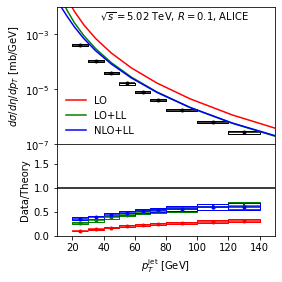

In [20]:

R, iR = 0.1, 0

# LO + LL
dsigma_dpT_dy_LO_LL = sigma_fold_JF(pT,  MakeSpectra(pT, dsigma_dpT_dy_q_lo), R, iR, 'q', 'LO')\
                    + sigma_fold_JF(pT,  MakeSpectra(pT, dsigma_dpT_dy_g_lo), R, iR, 'g', 'LO')
# LO + LL + NLL
dsigma_dpT_dy_NLO_LL = dsigma_dpT_dy_LO_LL\
                     + sigma_fold_JF(pT,  MakeSpectra(pT, dsigma_dpT_dy_q_lo), R, iR, 'q', 'NLO')\
                     + sigma_fold_JF(pT,  MakeSpectra(pT, dsigma_dpT_dy_g_lo), R, iR, 'g', 'NLO')\
                     + sigma_fold_JF(pT,  MakeSpectra(pT, dsigma_dpT_dy_q_nlo), R, iR, 'q', 'LO')\
                     + sigma_fold_JF(pT,  MakeSpectra(pT, dsigma_dpT_dy_g_nlo), R, iR, 'g', 'LO')

fig = plt.figure(figsize=(4,4))
gs = gridspec.GridSpec(5, 1)
ax1 = fig.add_subplot(gs[:3])
ax2 = fig.add_subplot(gs[3:])

# dsigma/dpT/dy
ax1.plot(pT, dsigma_dpT_dy_LO, 'r', label='LO')
ax1.plot(pT, dsigma_dpT_dy_LO_LL, 'g', label='LO+LL')
ax1.plot(pT, dsigma_dpT_dy_NLO_LL, 'b', label="NLO+LL")
plot_exp(R, ax1)

ax1.semilogy()
ax1.set_ylim(1e-7,1e-2)
ax1.set_xlim(10,150)
ax1.set_xticks([])
ax1.legend(loc='lower left', framealpha=0.)
ax1.set_ylabel(r"$d\sigma/d\eta/dp_T$ [mb/GeV]")
ax1.annotate(r"$\sqrt{{s}}=5.02$ TeV, $R={}$, ALICE".format(R), xy=(.2,.9), xycoords='axes fraction')


# Exp/Theory
plot_exp(R, ax2, color='r', scale=MakeSpectra(pT, dsigma_dpT_dy_LO) )
plot_exp(R, ax2, color='g', scale=MakeSpectra(pT, dsigma_dpT_dy_LO_LL) )
plot_exp(R, ax2, color='b', scale=MakeSpectra(pT, dsigma_dpT_dy_NLO_LL) )

ax2.set_ylim(0,1.9)
ax2.plot([0,150],[1,1], 'k-')
ax2.set_xlim(10,150)
ax2.set_xlabel(r"$p_T^{\rm jet}$ [GeV]")
ax2.set_ylabel(r"Data/Theory")

plt.tight_layout(True)
plt.subplots_adjust(hspace=0)
plt.savefig("ALICE-jet-R0d1.png", dpi=300)


/tmp/ipykernel_899064/1872065535.py:46: MatplotlibDeprecationWarning: Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  plt.tight_layout(True)


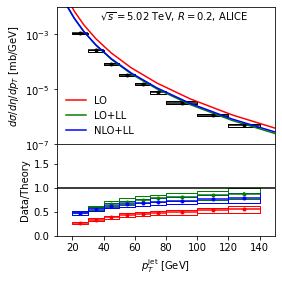

In [21]:

R, iR = 0.2, 1

# LO + LL
dsigma_dpT_dy_LO_LL = sigma_fold_JF(pT,  MakeSpectra(pT, dsigma_dpT_dy_q_lo), R, iR, 'q', 'LO')\
                    + sigma_fold_JF(pT,  MakeSpectra(pT, dsigma_dpT_dy_g_lo), R, iR, 'g', 'LO')
# LO + LL + NLL
dsigma_dpT_dy_NLO_LL = dsigma_dpT_dy_LO_LL\
                     + sigma_fold_JF(pT,  MakeSpectra(pT, dsigma_dpT_dy_q_lo), R, iR, 'q', 'NLO')\
                     + sigma_fold_JF(pT,  MakeSpectra(pT, dsigma_dpT_dy_g_lo), R, iR, 'g', 'NLO')\
                     + sigma_fold_JF(pT,  MakeSpectra(pT, dsigma_dpT_dy_q_nlo), R, iR, 'q', 'LO')\
                     + sigma_fold_JF(pT,  MakeSpectra(pT, dsigma_dpT_dy_g_nlo), R, iR, 'g', 'LO')

fig = plt.figure(figsize=(4,4))
gs = gridspec.GridSpec(5, 1)
ax1 = fig.add_subplot(gs[:3])
ax2 = fig.add_subplot(gs[3:])

# dsigma/dpT/dy
ax1.plot(pT, dsigma_dpT_dy_LO, 'r', label='LO')
ax1.plot(pT, dsigma_dpT_dy_LO_LL, 'g', label='LO+LL')
ax1.plot(pT, dsigma_dpT_dy_NLO_LL, 'b', label="NLO+LL")
plot_exp(R, ax1)

ax1.semilogy()
ax1.set_ylim(1e-7,1e-2)
ax1.set_xlim(10,150)
ax1.set_xticks([])
ax1.legend(loc='lower left', framealpha=0.)
ax1.set_ylabel(r"$d\sigma/d\eta/dp_T$ [mb/GeV]")
ax1.annotate(r"$\sqrt{{s}}=5.02$ TeV, $R={}$, ALICE".format(R), xy=(.2,.9), xycoords='axes fraction')


# Exp/Theory
plot_exp(R, ax2, color='r', scale=MakeSpectra(pT, dsigma_dpT_dy_LO) )
plot_exp(R, ax2, color='g', scale=MakeSpectra(pT, dsigma_dpT_dy_LO_LL) )
plot_exp(R, ax2, color='b', scale=MakeSpectra(pT, dsigma_dpT_dy_NLO_LL) )

ax2.set_ylim(0,1.9)
ax2.plot([0,150],[1,1], 'k-')
ax2.set_xlim(10,150)
ax2.set_xlabel(r"$p_T^{\rm jet}$ [GeV]")
ax2.set_ylabel(r"Data/Theory")



plt.tight_layout(True)
plt.subplots_adjust(hspace=0)
plt.savefig("ALICE-jet-R0d2.png", dpi=300)


/tmp/ipykernel_899064/1173430698.py:46: MatplotlibDeprecationWarning: Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  plt.tight_layout(True)


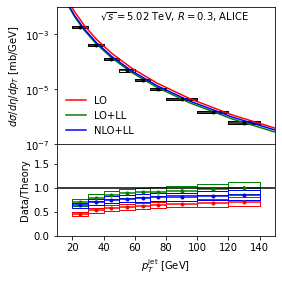

In [22]:

R, iR = 0.3, 2

# LO + LL
dsigma_dpT_dy_LO_LL = sigma_fold_JF(pT,  MakeSpectra(pT, dsigma_dpT_dy_q_lo), R, iR, 'q', 'LO')\
                    + sigma_fold_JF(pT,  MakeSpectra(pT, dsigma_dpT_dy_g_lo), R, iR, 'g', 'LO')
# LO + LL + NLL
dsigma_dpT_dy_NLO_LL = dsigma_dpT_dy_LO_LL\
                     + sigma_fold_JF(pT,  MakeSpectra(pT, dsigma_dpT_dy_q_lo), R, iR, 'q', 'NLO')\
                     + sigma_fold_JF(pT,  MakeSpectra(pT, dsigma_dpT_dy_g_lo), R, iR, 'g', 'NLO')\
                     + sigma_fold_JF(pT,  MakeSpectra(pT, dsigma_dpT_dy_q_nlo), R, iR, 'q', 'LO')\
                     + sigma_fold_JF(pT,  MakeSpectra(pT, dsigma_dpT_dy_g_nlo), R, iR, 'g', 'LO')

fig = plt.figure(figsize=(4,4))
gs = gridspec.GridSpec(5, 1)
ax1 = fig.add_subplot(gs[:3])
ax2 = fig.add_subplot(gs[3:])

# dsigma/dpT/dy
ax1.plot(pT, dsigma_dpT_dy_LO, 'r', label='LO')
ax1.plot(pT, dsigma_dpT_dy_LO_LL, 'g', label='LO+LL')
ax1.plot(pT, dsigma_dpT_dy_NLO_LL, 'b', label="NLO+LL")
plot_exp(R, ax1)

ax1.semilogy()
ax1.set_ylim(1e-7,1e-2)
ax1.set_xlim(10,150)
ax1.set_xticks([])
ax1.legend(loc='lower left', framealpha=0.)
ax1.set_ylabel(r"$d\sigma/d\eta/dp_T$ [mb/GeV]")
ax1.annotate(r"$\sqrt{{s}}=5.02$ TeV, $R={}$, ALICE".format(R), xy=(.2,.9), xycoords='axes fraction')


# Exp/Theory
plot_exp(R, ax2, color='r', scale=MakeSpectra(pT, dsigma_dpT_dy_LO) )
plot_exp(R, ax2, color='g', scale=MakeSpectra(pT, dsigma_dpT_dy_LO_LL) )
plot_exp(R, ax2, color='b', scale=MakeSpectra(pT, dsigma_dpT_dy_NLO_LL) )

ax2.set_ylim(0,1.9)
ax2.plot([0,150],[1,1], 'k-')
ax2.set_xlim(10,150)
ax2.set_xlabel(r"$p_T^{\rm jet}$ [GeV]")
ax2.set_ylabel(r"Data/Theory")



plt.tight_layout(True)
plt.subplots_adjust(hspace=0)
plt.savefig("ALICE-jet-R0d3.png", dpi=300)


/tmp/ipykernel_899064/2493928794.py:46: MatplotlibDeprecationWarning: Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  plt.tight_layout(True)


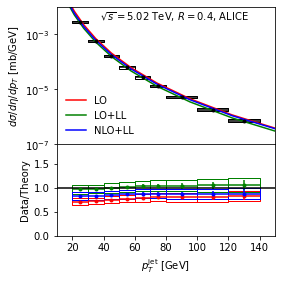

In [23]:

R, iR = 0.4, 3

# LO + LL
dsigma_dpT_dy_LO_LL = sigma_fold_JF(pT,  MakeSpectra(pT, dsigma_dpT_dy_q_lo), R, iR, 'q', 'LO')\
                    + sigma_fold_JF(pT,  MakeSpectra(pT, dsigma_dpT_dy_g_lo), R, iR, 'g', 'LO')
# LO + LL + NLL
dsigma_dpT_dy_NLO_LL = dsigma_dpT_dy_LO_LL\
                     + sigma_fold_JF(pT,  MakeSpectra(pT, dsigma_dpT_dy_q_lo), R, iR, 'q', 'NLO')\
                     + sigma_fold_JF(pT,  MakeSpectra(pT, dsigma_dpT_dy_g_lo), R, iR, 'g', 'NLO')\
                     + sigma_fold_JF(pT,  MakeSpectra(pT, dsigma_dpT_dy_q_nlo), R, iR, 'q', 'LO')\
                     + sigma_fold_JF(pT,  MakeSpectra(pT, dsigma_dpT_dy_g_nlo), R, iR, 'g', 'LO')

fig = plt.figure(figsize=(4,4))
gs = gridspec.GridSpec(5, 1)
ax1 = fig.add_subplot(gs[:3])
ax2 = fig.add_subplot(gs[3:])

# dsigma/dpT/dy
ax1.plot(pT, dsigma_dpT_dy_LO, 'r', label='LO')
ax1.plot(pT, dsigma_dpT_dy_LO_LL, 'g', label='LO+LL')
ax1.plot(pT, dsigma_dpT_dy_NLO_LL, 'b', label="NLO+LL")
plot_exp(R, ax1)

ax1.semilogy()
ax1.set_ylim(1e-7,1e-2)
ax1.set_xlim(10,150)
ax1.set_xticks([])
ax1.legend(loc='lower left', framealpha=0.)
ax1.set_ylabel(r"$d\sigma/d\eta/dp_T$ [mb/GeV]")
ax1.annotate(r"$\sqrt{{s}}=5.02$ TeV, $R={}$, ALICE".format(R), xy=(.2,.9), xycoords='axes fraction')


# Exp/Theory
plot_exp(R, ax2, color='r', scale=MakeSpectra(pT, dsigma_dpT_dy_LO) )
plot_exp(R, ax2, color='g', scale=MakeSpectra(pT, dsigma_dpT_dy_LO_LL) )
plot_exp(R, ax2, color='b', scale=MakeSpectra(pT, dsigma_dpT_dy_NLO_LL) )

ax2.set_ylim(0,1.9)
ax2.plot([0,150],[1,1], 'k-')
ax2.set_xlim(10,150)
ax2.set_xlabel(r"$p_T^{\rm jet}$ [GeV]")
ax2.set_ylabel(r"Data/Theory")



plt.tight_layout(True)
plt.subplots_adjust(hspace=0)
plt.savefig("ALICE-jet-R0d4.png", dpi=300)


# CMS 2.76 TeV, R=0.2, 0.3,  0.4

In [24]:
# 1609.05383

# quark spectra, LO and NLO correction
pT, dsigma_dpT_dy_g_lo = np.loadtxt("/home/weiyaoke/Research/NLO_initial_parton_spectra/qqbar/pp2g-2760GeV-LO-CT14nlo.dat").T
pT, dsigma_dpT_dy_g_nlo = np.loadtxt("/home/weiyaoke/Research/NLO_initial_parton_spectra/qqbar/pp2g-2760GeV-NLO-CT14nlo.dat").T
dsigma_dpT_dy_g_nlo -= dsigma_dpT_dy_g_lo

# qluon spectra, LO and NLO correction
pT, dsigma_dpT_dy_q_lo = np.loadtxt("/home/weiyaoke/Research/NLO_initial_parton_spectra/qqbar/pp2qqbar-2760GeV-LO-CT14nlo.dat").T
pT, dsigma_dpT_dy_q_nlo = np.loadtxt("/home/weiyaoke/Research/NLO_initial_parton_spectra/qqbar/pp2qqbar-2760GeV-NLO-CT14nlo.dat").T
dsigma_dpT_dy_q_nlo -= dsigma_dpT_dy_q_lo

Ymax = 2
dsigma_dpT_dy_q_lo /= 2*Ymax
dsigma_dpT_dy_g_lo /= 2*Ymax
dsigma_dpT_dy_q_nlo /= 2*Ymax
dsigma_dpT_dy_g_nlo /= 2*Ymax

# LO jet cross section, parton level
dsigma_dpT_dy_LO = dsigma_dpT_dy_q_lo + dsigma_dpT_dy_g_lo

# Load data
def plot_exp(R, ax, color='k', scale=lambda x: 0):
    pT, pTl, pTh, y, stat, _, sys, _ = np.loadtxt("./Data/CMS-pp2.76-R{}.dat".format(R)).T
    # pb -> mb
    y /= 10**6 
    sys /= 10**6
    
    y0 = np.array([np.exp(scale(np.log(np.linspace(L,H,10)))).mean() 
                         for L, H in zip(pTl, pTh)])
    y /= y0
    stat /= y0
    sys /= y0
    ax.errorbar(pT, y, xerr=(pTh-pTl)/2., yerr=stat, fmt='.', color=color)
    
    for il, ih, yl, yh in zip(pTl, pTh, y-sys, y+sys):
        ax.fill_between([il,ih], [yl,yl], [yh,yh], facecolor='none', edgecolor=color)

/tmp/ipykernel_899064/4166334325.py:47: MatplotlibDeprecationWarning: Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  plt.tight_layout(True)


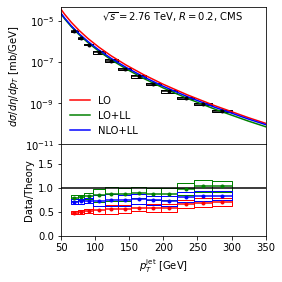

In [25]:
R, iR = 0.2, 1

# LO + LL
dsigma_dpT_dy_LO_LL = sigma_fold_JF(pT,  MakeSpectra(pT, dsigma_dpT_dy_q_lo), R, iR, 'q', 'LO')\
                    + sigma_fold_JF(pT,  MakeSpectra(pT, dsigma_dpT_dy_g_lo), R, iR, 'g', 'LO')
# LO + LL + NLL
dsigma_dpT_dy_NLO_LL = dsigma_dpT_dy_LO_LL\
                     + sigma_fold_JF(pT,  MakeSpectra(pT, dsigma_dpT_dy_q_lo), R, iR, 'q', 'NLO')\
                     + sigma_fold_JF(pT,  MakeSpectra(pT, dsigma_dpT_dy_g_lo), R, iR, 'g', 'NLO')\
                     + sigma_fold_JF(pT,  MakeSpectra(pT, dsigma_dpT_dy_q_nlo), R, iR, 'q', 'LO')\
                     + sigma_fold_JF(pT,  MakeSpectra(pT, dsigma_dpT_dy_g_nlo), R, iR, 'g', 'LO')

fig = plt.figure(figsize=(4,4))
gs = gridspec.GridSpec(5, 1)
ax1 = fig.add_subplot(gs[:3])
ax2 = fig.add_subplot(gs[3:])

# dsigma/dpT/dy
ax1.plot(pT, dsigma_dpT_dy_LO, 'r', label='LO')
ax1.plot(pT, dsigma_dpT_dy_LO_LL, 'g', label='LO+LL')
ax1.plot(pT, dsigma_dpT_dy_NLO_LL, 'b', label="NLO+LL")
plot_exp(R, ax1)

ax1.semilogy()
ax1.set_ylim(1e-11,5e-5)

ax1.set_xlim(50,350)
ax1.set_xticks([])
ax1.legend(loc='lower left', framealpha=0.)
ax1.set_ylabel(r"$d\sigma/d\eta/dp_T$ [mb/GeV]")
ax1.annotate(r"$\sqrt{{s}}=2.76$ TeV, $R={}$, CMS".format(R), xy=(.2,.9), xycoords='axes fraction')


# Exp/Theory
plot_exp(R, ax2, color='r', scale=MakeSpectra(pT, dsigma_dpT_dy_LO) )
plot_exp(R, ax2, color='g', scale=MakeSpectra(pT, dsigma_dpT_dy_LO_LL) )
plot_exp(R, ax2, color='b', scale=MakeSpectra(pT, dsigma_dpT_dy_NLO_LL) )

ax2.set_ylim(0,1.9)
ax2.plot([50,350],[1,1], 'k-')
ax2.set_xlim(50,350)
ax2.set_xlabel(r"$p_T^{\rm jet}$ [GeV]")
ax2.set_ylabel(r"Data/Theory")



plt.tight_layout(True)
plt.subplots_adjust(hspace=0)
plt.savefig("CMS-jet-R0d2.png", dpi=300)


/tmp/ipykernel_899064/3023041715.py:47: MatplotlibDeprecationWarning: Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  plt.tight_layout(True)


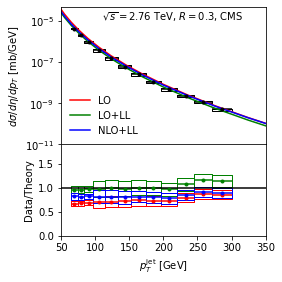

In [26]:
R, iR = 0.3, 2

# LO + LL
dsigma_dpT_dy_LO_LL = sigma_fold_JF(pT,  MakeSpectra(pT, dsigma_dpT_dy_q_lo), R, iR, 'q', 'LO')\
                    + sigma_fold_JF(pT,  MakeSpectra(pT, dsigma_dpT_dy_g_lo), R, iR, 'g', 'LO')
# LO + LL + NLL
dsigma_dpT_dy_NLO_LL = dsigma_dpT_dy_LO_LL\
                     + sigma_fold_JF(pT,  MakeSpectra(pT, dsigma_dpT_dy_q_lo), R, iR, 'q', 'NLO')\
                     + sigma_fold_JF(pT,  MakeSpectra(pT, dsigma_dpT_dy_g_lo), R, iR, 'g', 'NLO')\
                     + sigma_fold_JF(pT,  MakeSpectra(pT, dsigma_dpT_dy_q_nlo), R, iR, 'q', 'LO')\
                     + sigma_fold_JF(pT,  MakeSpectra(pT, dsigma_dpT_dy_g_nlo), R, iR, 'g', 'LO')

fig = plt.figure(figsize=(4,4))
gs = gridspec.GridSpec(5, 1)
ax1 = fig.add_subplot(gs[:3])
ax2 = fig.add_subplot(gs[3:])

# dsigma/dpT/dy
ax1.plot(pT, dsigma_dpT_dy_LO, 'r', label='LO')
ax1.plot(pT, dsigma_dpT_dy_LO_LL, 'g', label='LO+LL')
ax1.plot(pT, dsigma_dpT_dy_NLO_LL, 'b', label="NLO+LL")
plot_exp(R, ax1)

ax1.semilogy()
ax1.set_ylim(1e-11,5e-5)

ax1.set_xlim(50,350)
ax1.set_xticks([])
ax1.legend(loc='lower left', framealpha=0.)
ax1.set_ylabel(r"$d\sigma/d\eta/dp_T$ [mb/GeV]")
ax1.annotate(r"$\sqrt{{s}}=2.76$ TeV, $R={}$, CMS".format(R), xy=(.2,.9), xycoords='axes fraction')


# Exp/Theory
plot_exp(R, ax2, color='r', scale=MakeSpectra(pT, dsigma_dpT_dy_LO) )
plot_exp(R, ax2, color='g', scale=MakeSpectra(pT, dsigma_dpT_dy_LO_LL) )
plot_exp(R, ax2, color='b', scale=MakeSpectra(pT, dsigma_dpT_dy_NLO_LL) )

ax2.set_ylim(0,1.9)
ax2.plot([50,350],[1,1], 'k-')
ax2.set_xlim(50,350)
ax2.set_xlabel(r"$p_T^{\rm jet}$ [GeV]")
ax2.set_ylabel(r"Data/Theory")



plt.tight_layout(True)
plt.subplots_adjust(hspace=0)
plt.savefig("CMS-jet-R0d3.png", dpi=300)


/tmp/ipykernel_899064/1798901772.py:47: MatplotlibDeprecationWarning: Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  plt.tight_layout(True)


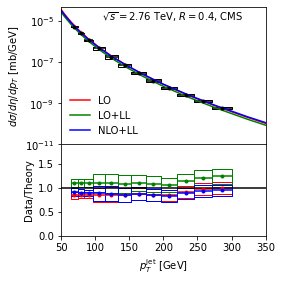

In [27]:
R, iR = 0.4, 3

# LO + LL
dsigma_dpT_dy_LO_LL = sigma_fold_JF(pT,  MakeSpectra(pT, dsigma_dpT_dy_q_lo), R, iR, 'q', 'LO')\
                    + sigma_fold_JF(pT,  MakeSpectra(pT, dsigma_dpT_dy_g_lo), R, iR, 'g', 'LO')
# LO + LL + NLL
dsigma_dpT_dy_NLO_LL = dsigma_dpT_dy_LO_LL\
                     + sigma_fold_JF(pT,  MakeSpectra(pT, dsigma_dpT_dy_q_lo), R, iR, 'q', 'NLO')\
                     + sigma_fold_JF(pT,  MakeSpectra(pT, dsigma_dpT_dy_g_lo), R, iR, 'g', 'NLO')\
                     + sigma_fold_JF(pT,  MakeSpectra(pT, dsigma_dpT_dy_q_nlo), R, iR, 'q', 'LO')\
                     + sigma_fold_JF(pT,  MakeSpectra(pT, dsigma_dpT_dy_g_nlo), R, iR, 'g', 'LO')

fig = plt.figure(figsize=(4,4))
gs = gridspec.GridSpec(5, 1)
ax1 = fig.add_subplot(gs[:3])
ax2 = fig.add_subplot(gs[3:])

# dsigma/dpT/dy
ax1.plot(pT, dsigma_dpT_dy_LO, 'r', label='LO')
ax1.plot(pT, dsigma_dpT_dy_LO_LL, 'g', label='LO+LL')
ax1.plot(pT, dsigma_dpT_dy_NLO_LL, 'b', label="NLO+LL")
plot_exp(R, ax1)

ax1.semilogy()
ax1.set_ylim(1e-11,5e-5)

ax1.set_xlim(50,350)
ax1.set_xticks([])
ax1.legend(loc='lower left', framealpha=0.)
ax1.set_ylabel(r"$d\sigma/d\eta/dp_T$ [mb/GeV]")
ax1.annotate(r"$\sqrt{{s}}=2.76$ TeV, $R={}$, CMS".format(R), xy=(.2,.9), xycoords='axes fraction')


# Exp/Theory
plot_exp(R, ax2, color='r', scale=MakeSpectra(pT, dsigma_dpT_dy_LO) )
plot_exp(R, ax2, color='g', scale=MakeSpectra(pT, dsigma_dpT_dy_LO_LL) )
plot_exp(R, ax2, color='b', scale=MakeSpectra(pT, dsigma_dpT_dy_NLO_LL) )

ax2.set_ylim(0,1.9)
ax2.plot([50,350],[1,1], 'k-')
ax2.set_xlim(50,350)
ax2.set_xlabel(r"$p_T^{\rm jet}$ [GeV]")
ax2.set_ylabel(r"Data/Theory")



plt.tight_layout(True)
plt.subplots_adjust(hspace=0)
plt.savefig("CMS-jet-R0d4.png", dpi=300)
